# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
from scipy import linalg

In [2]:
# PATH_TO_DATA = "../../data/"
PATH_TO_DATA = 'data/'

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                word = word.lower()
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = {}
        for j in self.word2vec.keys():
            scores[j] = self.score(w, j)
        
        words = np.array(list(scores.keys()))
        scores_list = np.array(list(scores.values()))
        ids = np.argsort(scores_list)
        top_words = []
        for i in range(5):
            top_words.append(words[ids[-i-2]])
        return  top_words

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        try:
            return np.dot(self.word2vec[w1], self.word2vec[w2]) / (np.linalg.norm(self.word2vec[w1])*np.linalg.norm(self.word2vec[w2]))
        except KeyError:
            return 'String Not Found'

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, w2v.most_similar(w1))

Loaded 19765 pretrained word vectors
cat dog 0.2510936879670139
dog pet 0.28149744895768625
dogs cats 0.6747577573530962
paris france 0.7058595452409975
germany berlin 0.7060253015336013
cat ['man', 'sat', 'pet', 'act', 'star']
dog ['dogs', 'puppy', 'canine', 'horse', 'pets']
dogs ['dog', 'pets', 'cats', 'animals', 'horses']
paris ['parisian', 'france', 'versailles', 'lyon', 'bordeaux']
germany ['austria', 'bavaria', 'berlin', 'munich', 'hamburg']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_emb = []
                for w in set(sent.split()):
                    list_emb.append(self.w2v.word2vec.get(w, np.zeros((300,))))
                total = 0
                for v in list_emb:
                    total += v
                sentemb.append(total/len(list_emb))
                
            else:
                # idf-weighted mean of word vectors
                list_emb = []
                for w in set(sent.split()):
                    list_emb.append(np.dot(self.w2v.word2vec.get(w, np.zeros((300,))), idf.get(w, 0)))
                total = 0
                for v in list_emb:
                    total += v
                sentemb.append(total/len(list_emb))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        score_list = np.array([])
        
        for i in range(len(keys)):
            score_list = np.concatenate((score_list, [self.score(s, sentences[i], idf)]), axis=0)
        
        sorted_index = np.argsort(-score_list)
        tops = []
        for j in range(1, K+1):
            tops.append(sentences[sorted_index[j]])    
        return tops

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        
        cs1 = self.encode([s1], idf)[0]
        cs2 = self.encode([s2], idf)[0]

        # print(cs1, cs2)
        
        return np.dot(cs1, cs2) / (np.linalg.norm(cs1)*np.linalg.norm(cs2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        for word in list(idf.keys()):
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    sentences = list(f)

no_idf = True   

# Build idf scores for each word
idf = {} if no_idf else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('' if not sentences else sentences[10], s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print('' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


no_idf = False

idf = {} if no_idf else s2v.build_idf(sentences) 
print('' if not sentences else sentences[10], s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print('' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 4367 pretrained word vectors


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


1 smiling african american boy . 
 ['an african american man smiling . \n', 'african american female in a gray dress . \n', 'african american woman bouncing black basketball \n', 'an african american male holding a microphone . \n', 'an african american man playing a saxophone . \n']
1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.5505701983202917
1 smiling african american boy . 
 ['an african american man smiling . \n', 'an african american man playing a saxophone . \n', 'an african american man is sitting . \n', 'african american woman bouncing black basketball \n', 'an african american in sunglasses and a white tee-shirt smiles . \n']
1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.5246814806185796


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

def load_wordvec(fname, nmax):
    word2vec = {}
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            word2vec[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    print('Loaded %s pretrained word vectors' % (len(word2vec)))
    return word2vec

word2vec_fr = load_wordvec('data/wiki.fr.vec', 50000)

word2vec_en = load_wordvec('data/wiki.en.vec', 50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
common_words = []
words_fr = list(word2vec_fr.keys())
words_en = list(word2vec_en.keys())

maxcount = 0
for word in words_fr:
    if word in words_en and maxcount < 20000:
        common_words.append(word)
        maxcount += 1
        
# print(common_words)


X = []
Y = []
for word in common_words:
    X.append(word2vec_fr[word])
    # print(X)
    Y.append(word2vec_en[word])
    
X = np.transpose(np.array(X))
Y = np.transpose(np.array(Y))
    
print(np.array(X).shape, len(Y), len(common_words))
# print(X)

(300, 18970) 300 18970


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
print(X[0][0])
print(Y[0][0])

print(np.dot(Y, np.transpose(X)).shape)

print(word2vec_fr['</s>'][0])
print(word2vec_en['</s>'][0])

U, s, Vh = linalg.svd(np.dot(Y, np.transpose(X)))

print(U.shape)
print(s.shape)
print(Vh.shape)

# W = np.dot(linalg.inv(U), linalg.inv(Vh))
W = np.dot(U, Vh)
print(W.shape)


0.28556
0.050258
(300, 300)
0.28556
0.050258
(300, 300)
(300,)
(300, 300)
(300, 300)


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

def score(word_fr, word_en, W, word2vec_fr, word2vec_en):
    word_fr_en_space = np.dot(W, word2vec_fr[word_fr])
    # print(word_fr_en_space.shape)
    # print(word2vec_en[word_en].shape)
    score = np.dot(np.transpose(word_fr_en_space), word2vec_en[word_en]) / (np.linalg.norm(word_fr_en_space) * np.linalg.norm(word2vec_en[word_en]))
    
    return abs(score)
    
word_test = 'montagne'
dict_scores = {}
for word in list(word2vec_en.keys()):
    dict_scores[word] = score(word_test, word, W, word2vec_fr, word2vec_en)
    
mini = 10000000
min_word = 0
for word in list(word2vec_en.keys()):
    if dict_scores[word] < mini:
        mini = dict_scores[word]
        min_word = word

scores = list(dict_scores.values())
close_words = np.array(list(dict_scores.keys()))

indices = np.argsort(scores)
wlist = []
print('Closest english words of montagne:')
for i in range(10):
    # print(indices[i])
#     print('closest word', i, close_words[indices[-i-1]])
#     print('score', scores[indices[i-1]])
#     print('\n')
    wlist.append(close_words[indices[-i-1]])
print(wlist)
    
word_test = 'manger'
dict_scores = {}
for word in list(word2vec_en.keys()):
    dict_scores[word] = score(word_test, word, W, word2vec_fr, word2vec_en)
    
mini = 10000000
min_word = 0
for word in list(word2vec_en.keys()):
    if dict_scores[word] < mini:
        mini = dict_scores[word]
        min_word = word

scores = list(dict_scores.values())
close_words = np.array(list(dict_scores.keys()))

indices = np.argsort(scores)
print('Closest english words of manger:')
wlist = []
for i in range(10):
    # print(indices[i])
#     print('closest word', i, close_words[indices[-i-1]])
#     print('score', scores[indices[i-1]])
#     print('\n')
    wlist.append(close_words[indices[-i-1]])
print(wlist)

word_test = 'bike'
dict_scores = {}
for word in list(word2vec_fr.keys()):
    dict_scores[word] = score(word, word_test, W, word2vec_fr, word2vec_en)
    
mini = 10000000
min_word = 0
for word in list(word2vec_fr.keys()):
    if dict_scores[word] < mini:
        mini = dict_scores[word]
        min_word = word

scores = list(dict_scores.values())
close_words = np.array(list(dict_scores.keys()))

indices = np.argsort(scores)
print('Closest french words of bike:')
wlist = []
for i in range(10):
    # print(indices[i])
#     print('closest word', i, close_words[indices[-i-1]])
#     print('score', scores[indices[i-1]])
#     print('\n')
    wlist.append(close_words[indices[-i-1]])
print(wlist)

word_test = 'eat'
dict_scores = {}
for word in list(word2vec_fr.keys()):
    dict_scores[word] = score(word, word_test, W, word2vec_fr, word2vec_en)
    
mini = 10000000
min_word = 0
for word in list(word2vec_fr.keys()):
    if dict_scores[word] < mini:
        mini = dict_scores[word]
        min_word = word

scores = list(dict_scores.values())
close_words = np.array(list(dict_scores.keys()))

indices = np.argsort(scores)
wlist = []
print('Closest french words of eat:')
for i in range(10):
    # print(indices[i])
#     print('closest word', i, close_words[indices[-i-1]])
#     print('score', scores[indices[i-1]])
#     print('\n')
    wlist.append(close_words[indices[-i-1]])
print(wlist)




Closest english words of montagne:
['mountain', 'mountains', 'massif', 'mountainous', 'slopes', 'alps', 'mont', 'foothills', 'summits', 'mountaineering']
Closest english words of manger:
['eat', 'meal', 'eating', 'eaten', 'ate', 'cooked', 'dining', 'sushi', 'dinner', 'kitchen']
Closest french words of bike:
['vélo', 'bike', 'vtt', 'bicycle', 'vélos', 'enduro', 'bmx', 'motocross', 'motocycliste', 'motos']
Closest french words of eat:
['mange', 'mangent', 'mangeant', 'manger', 'eat', 'consommer', 'mangé', 'consomment', 'consommés', 'consomme']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

def load_txt(path):
    with open(path, encoding='utf-8') as f:
        return f.read()

    
test_txt = load_txt('data/SST/stsa.fine.test.X')
train_txt = load_txt('data/SST/stsa.fine.train')
dev_txt = load_txt('data/SST/stsa.fine.dev')

In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
idf = s2v.build_idf(train_txt.split('\n')) 

train_array = []
train_labels = []
train_array_idf = []
for data in train_txt.split('\n'):
    
    try:
        label = data[0]
        sentence = data[2:]

        a = s2v.encode([sentence])
        train_array.append(a[0])
        train_labels.append(int(label))
        a = s2v.encode([sentence], idf)
        train_array_idf.append(a[0])
    except:
        pass
    
dev_array = []
dev_labels = []
dev_array_idf = []
for data in dev_txt.split('\n'):  
    try:
        label = data[0]
        sentence = data[2:]

        a = s2v.encode([sentence])
        dev_array.append(a[0])
        dev_labels.append(int(label))
        a = s2v.encode([sentence], idf)
        dev_array_idf.append(a[0])
    except:
        pass
    
test_array = []
test_array_idf = []
for data in test_txt.split('\n'):
    try:
        a = s2v.encode([data])
        test_array.append(a[0])
        a = s2v.encode([data], idf)
        test_array_idf.append(a[0])
    except:
        pass

print(train_labels[0:20])

[4, 1, 1, 2, 3, 2, 3, 3, 1, 4, 1, 1, 3, 1, 1, 4, 3, 3, 1, 4]


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_array, train_labels)


print('SCORE TRAINING SET', clf.score(train_array, train_labels))
print('SCORE DEV SET', clf.score(dev_array, dev_labels))

y_predicted = clf.predict(dev_array)

print(classification_report(dev_labels, y_predicted))

# Using the idf-mean encoding
print('USING THE IDF-MEAN ENCODING:')
clf_idf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_array_idf, train_labels)


print('SCORE TRAINING SET', clf_idf.score(train_array_idf, train_labels))
print('SCORE DEV SET', clf_idf.score(dev_array, dev_labels))

y_predicted = clf_idf.predict(dev_array_idf)

print(classification_report(dev_labels, y_predicted))

SCORE TRAINING SET 0.43316947565543074
SCORE DEV SET 0.37057220708446864
             precision    recall  f1-score   support

          0       0.39      0.09      0.15       139
          1       0.38      0.54      0.45       289
          2       0.36      0.12      0.18       229
          3       0.35      0.63      0.45       279
          4       0.46      0.22      0.30       165

avg / total       0.38      0.37      0.33      1101

USING THE IDF-MEAN ENCODING:
SCORE TRAINING SET 0.44159644194756553
SCORE DEV SET 0.35513169845594916
             precision    recall  f1-score   support

          0       0.28      0.12      0.16       139
          1       0.38      0.50      0.43       289
          2       0.36      0.17      0.23       229
          3       0.34      0.55      0.42       279
          4       0.39      0.25      0.31       165

avg / total       0.35      0.36      0.34      1101



In [15]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
predictions = clf.predict(test_array[:2210])

print(predictions[:5])
with open("logreg_bov_y_test_sst.txt", 'w') as file:
    for pred in predictions:
        file.write(str(pred) + '\n')

[1 3 2 1 1]


In [16]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)

clf.fit(train_array, train_labels)
print('SCORE TRAINING SET', clf.score(train_array, train_labels))

y_predicted = clf.predict(dev_array)

print(classification_report(dev_labels, y_predicted))

predictions = clf.predict(test_array[:2210])
print(predictions[:5])
with open("svm_bov_y_test_sst.txt", 'w') as file:
    for pred in predictions:
        file.write(str(pred) + '\n')

SCORE TRAINING SET 0.43913857677902624
             precision    recall  f1-score   support

          0       0.36      0.12      0.17       139
          1       0.39      0.55      0.46       289
          2       0.35      0.14      0.20       229
          3       0.35      0.56      0.43       279
          4       0.40      0.27      0.32       165

avg / total       0.37      0.37      0.34      1101

[1 3 2 1 1]


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import keras

Using TensorFlow backend.


In [15]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "../../data/"

# TYPE CODE HERE

def load_txt(path):
    with open(path, encoding='utf-8') as f:
        return f.read()

    
test_txt = load_txt('data/SST/stsa.fine.test.X')
train_txt = load_txt('data/SST/stsa.fine.train')
dev_txt = load_txt('data/SST/stsa.fine.dev')
print(train_txt)



4 a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
1 apparently reassembled from the cutting-room floor of any given daytime soap .
1 they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
2 the entire movie is filled with deja vu moments .
3 this is a visually stunning rumination on love , memory , history and the war between art and commerce .
2 um , no. .
3 jonathan parker 's bartleby should have been the be-all-end-all of the modern-office anomie films .
3 campanella gets the tone just right -- funny in the middle of sad in the middle of hopeful .
1 a fan film that for the uninitiated plays better on video with the sound turned down .
4 béart and berling are both superb , while huppert ... is magnificent .
1 a little less extreme than in the past , with longer

In [16]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
train = train_txt.split('\n')
train_hot_encode = []
train_labels = []
for data in train:
    try:
        label = data[0]
        sentence = data[2:]
        A = keras.preprocessing.text.one_hot(sentence, 25000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
        train_hot_encode.append(A)
        if label == '0':
            train_labels.append([1, 0, 0, 0, 0])
        elif label == '1':
            train_labels.append([0, 1, 0, 0, 0])
        elif label == '2':
            train_labels.append([0, 0, 1, 0, 0])
        elif label == '3':
            train_labels.append([0, 0, 0, 1, 0])
        elif label == '4':
            train_labels.append([0, 0, 0, 0, 1])
        else:
            print(label)
    except:
        pass
train_labels = np.array(train_labels)
# print(train_labels)
# print(train_hot_encode)

dev = dev_txt.split('\n')
dev_hot_encode = []
dev_labels = []
for data in dev:
    try:
        label = data[0]
        sentence = data[2:]
        A = keras.preprocessing.text.one_hot(sentence, 25000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
        dev_hot_encode.append(A)
        if label == '0':
            dev_labels.append([1, 0, 0, 0, 0])
        elif label == '1':
            dev_labels.append([0, 1, 0, 0, 0])
        elif label == '2':
            dev_labels.append([0, 0, 1, 0, 0])
        elif label == '3':
            dev_labels.append([0, 0, 0, 1, 0])
        elif label == '4':
            dev_labels.append([0, 0, 0, 0, 1])
        else:
            print(label)
    except:
        pass

dev_labels = np.array(dev_labels)

test = test_txt.split('\n')
test_hot_encode = []

for data in test:
    sentence = data
    A = keras.preprocessing.text.one_hot(sentence, 25000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
    test_hot_encode.append(A)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [17]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
train_pad = keras.preprocessing.sequence.pad_sequences(train_hot_encode, maxlen=52)
test_pad = keras.preprocessing.sequence.pad_sequences(test_hot_encode, maxlen=52)
dev_pad = keras.preprocessing.sequence.pad_sequences(dev_hot_encode, maxlen=52)
print(train_pad.shape)
print(test_pad.shape)
print(dev_pad.shape)

(8544, 52)
(2211, 52)
(1101, 52)


## 4.2 - Design and train your model

In [18]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = len(train_pad[0])  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 25000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`


In [19]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 52)          1300000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               92672     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,393,317
Trainable params: 1,393,317
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Vincent\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Train on 8544 samples, validate on 1101 samples
Epoch 1/2
8544/8544 [==============================] - 14s 2ms/step - loss: 1.5638 - acc: 0.2882 - val_loss: 1.5170 - val_acc: 0.3515
Epoch 2/2
8544/8544 [==============================] - 12s 1ms/step - loss: 1.3599 - acc: 0.4206 - val_loss: 1.3849 - val_acc: 0.3851


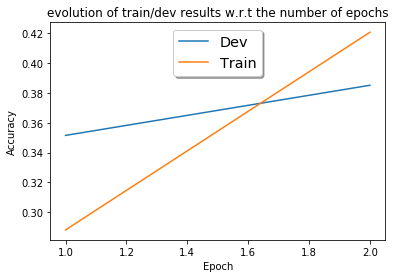

In [20]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
from sklearn.model_selection import train_test_split
bs = 64
n_epochs = 2

x_train = train_pad
y_train = train_labels
x_val = dev_pad
y_val = dev_labels
x_test = test_pad

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_val, y_val))

import matplotlib.pyplot as plt

h_d = history.history

plt.plot(range(1, n_epochs+1), h_d['val_acc'], label='Dev')
plt.plot(range(1, n_epochs+1), h_d['acc'], label='Train')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('evolution of train/dev results w.r.t the number of epochs')
plt.show()

In [21]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

def get_pos_max(l):
    m = max(l)
    return [i for i, j in enumerate(l) if j == m]


x_test = test_pad
predictions = model.predict(x_test)
with open("logreg_lstm_y_test_sst.txt", 'w') as file:
    for pred in predictions:
        u = get_pos_max(pred)[0]
        file.write(str(u) + '\n')
        
preds = model.predict(x_val)
y_pred = []
y_val_ = []
for i in preds:
    y_pred.append(get_pos_max(i)[0])
for i in y_val:
    y_val_.append(get_pos_max(i)[0])

print(classification_report(y_val_, y_pred))

             precision    recall  f1-score   support

          0       0.39      0.15      0.22       139
          1       0.40      0.61      0.48       289
          2       0.00      0.00      0.00       229
          3       0.36      0.65      0.46       279
          4       0.46      0.28      0.35       165

avg / total       0.31      0.39      0.32      1101



## 4.3 -- innovate !

In [106]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, Flatten, Dropout

train_sentences = []
for sent in train_txt.split('\n'):
    if sent[2:] != '':
        train_sentences.append(sent[2:])
dev_sentences = []
for sent in dev_txt.split('\n'):
    if sent[2:] != '':
        dev_sentences.append(sent[2:])
test_sentences = []
for sent in test_txt.split('\n'):
    if sent != '':
        test_sentences.append(sent)

idf = s2v.build_idf(train_sentences)

x_train = s2v.encode(train_sentences, idf)
x_val = s2v.encode(dev_sentences, idf)
x_test = s2v.encode(test_sentences, idf)
    
x_train = x_train.reshape((8544, 300, 1))
x_dev = x_val.reshape((1101, 300, 1))
x_test = x_test.reshape((2210, 300, 1))


vocab_size = 25000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation = 'relu', input_shape=(300,1)))
# model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())


bs = 32
n_epochs = 10
history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_val))


predictions = model.predict(x_test)

with open('cnn_y_test_sst.txt', 'w') as file:
    for pred in predictions:
        file.write(str(np.argmax(pred)) + "\n")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 298, 32)           128       
_________________________________________________________________
flatten_7 (Flatten)          (None, 9536)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               953700    
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 505       
Total params: 954,333
Trainable params: 954,333
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 9s 1ms/step - loss: 1.5002 - acc: 0.3292 - val_loss: 1.4486 - val_acc: 0.3706
Epoch 2/10
8544/8544 [==============================] - 7s 762us/step - loss: 1.4